# F1 Data Preprocessing

Part 1: Preprocessing the data. I am starting by merging datasets with results on raceId or driverId.

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# loading datasets
datasets_path = 'datasets'
drivers = pd.read_csv(os.path.join(datasets_path, 'drivers.csv'))
results = pd.read_csv(os.path.join(datasets_path, 'results.csv'))
races = pd.read_csv(os.path.join(datasets_path, 'races.csv'))
constructors = pd.read_csv(os.path.join(datasets_path, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(datasets_path, 'circuits.csv'))
status = pd.read_csv(os.path.join(datasets_path, 'status.csv')) 
qualifying = pd.read_csv(os.path.join(datasets_path, 'qualifying.csv'))
constructor_standings = pd.read_csv(os.path.join(datasets_path, 'constructor_standings.csv'))

print('drivers', drivers.shape)
print('results', results.shape)
print('races', races.shape)
print('constructors', constructors.shape)
print('circuits', circuits.shape)

drivers (861, 9)
results (26759, 18)
races (1125, 18)
constructors (212, 5)
circuits (77, 9)


## Merging Datasets

I merged datasets to create 4 new ones that show result x qualifiers, results x drivers, results x circuits, and results x constuctors.

In [41]:
drv = drivers.copy()
res = results.copy()
r = races.copy()
cons = constructors.copy()
con_standings = constructor_standings.copy()
cir = circuits.copy()
qualis = qualifying.copy()

# merged results with qualifying datasets
res_qualis = pd.merge(res, qualis, on=['raceId', 'driverId'], how='left').dropna()

# merged results with drivers datasets
res_drivers = pd.merge(res, drv[['driverId', 'driverRef']], on='driverId', how='left').dropna()

# merged races and circuits datasets and results
races_circuits = pd.merge(r, cir[['circuitId', 'circuitRef']], on='circuitId', how='left').dropna()
races_circuits_res = pd.merge(res, races_circuits, on='raceId', how='left').dropna()

# merged results with constructors datasets
constructors_cstandings = pd.merge(cons, con_standings, on='constructorId', how='left').dropna()
res_constructors = pd.merge(r, constructors_cstandings, on='raceId', how='left').dropna()

## EDA

Testing the different merged datasets to find influences on race results.

            position_y  position_x
position_y    1.000000    0.743359
position_x    0.743359    1.000000


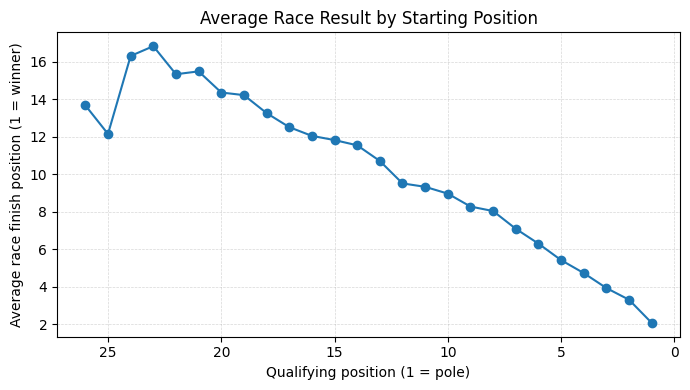

In [ ]:
# this shows how the starting position from qualifying correlates with the end position.

# cleaning
tmp = res_qualis.copy()

for col in ['position_x', 'position_y']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['position_x', 'position_y'])

tmp = tmp[(tmp['position_x'] > 0) & (tmp['position_y'] > 0)]

print(tmp[['position_y', 'position_x']].corr())

# calculating average finish position by starting position
avg_finish = (
    tmp.groupby('position_y')['position_x']
       .mean()
       .reset_index()
       .sort_values('position_y')
)

# plotting
plt.figure(figsize=(7, 4))
plt.plot(avg_finish['position_y'], avg_finish['position_x'], marker='o')
plt.xlabel("Qualifying position (1 = pole)")
plt.ylabel("Average race finish position (1 = winner)")
plt.title("Average Race Result by Starting Position")
plt.gca().invert_xaxis() 
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


circuitRef
phoenix         6.944444
zeltweg         6.666667
detroit         6.430556
zolder          5.965812
jacarepagua     5.834783
donington       5.818182
nivelles        5.812500
dallas          5.625000
long_beach      5.421687
adelaide        5.314961
jarama          5.149533
brands_hatch    5.143750
indianapolis    5.086687
montjuic        5.081081
lemans          5.000000
Name: pos_gain, dtype: float64


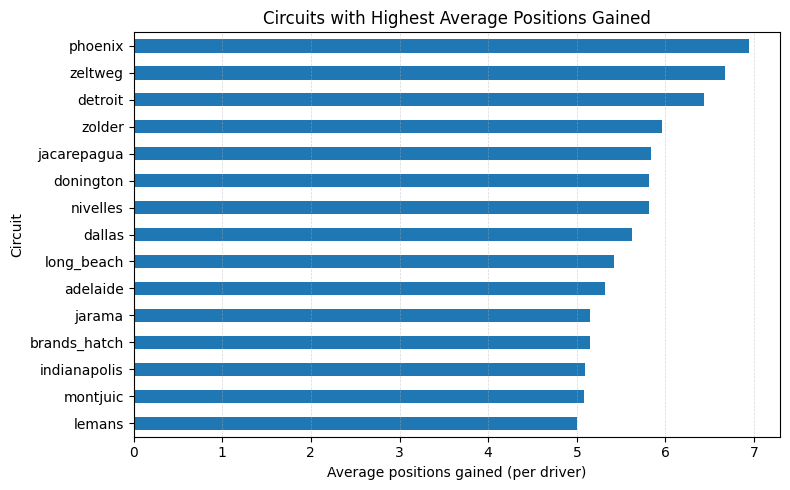

In [ ]:
# Finding circuits with the highest average positions gained

# cleaning data
tmp = races_circuits_res.copy()

for col in ['grid', 'position']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['grid', 'position'])
tmp = tmp[(tmp['grid'] > 0) & (tmp['position'] > 0)]

tmp['pos_gain'] = tmp['grid'] - tmp['position']

# calculating average gains
circuit_gain = (
    tmp.groupby('circuitRef')['pos_gain']
       .mean()
       .sort_values(ascending=False)
)

top_circuits = circuit_gain.head(15)
print(top_circuits)

# plotting
plt.figure(figsize=(8, 5))
top_circuits.sort_values().plot(kind='barh')
plt.xlabel("Average positions gained (per driver)")
plt.ylabel("Circuit")
plt.title("Circuits with Highest Average Positions Gained")
plt.grid(True, axis='x', linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()